# 영화리뷰 텍스트 감성분석하기
# Step1. 데이터준비

In [ ]:
# Mecab 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [4]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [5]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration_Data/ex8/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration_Data/ex8/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


위에서 불러온 데이터같은경우 전혀 가공되지 않은 텍스트 파일입니다. 따라서 해당 데이터를 가공해주는 함수를 만들어보겠습니다. 해당 함수안에서는 다음과 같은 작업이 수행됩니다.

- 데이터 중복 제거
- 결측치 제거
- 토큰화
- 불용어(Stopwords)제거
- 사전 구성 (word_to_index)
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복치, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    # 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # 딕셔너리형태로 각 요소의 개수를 세줌
    counter = counter.most_common(10000-4) # 딕셔너리요소를 튜플형태로만들고 리스트에담음
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] 
    word_to_index = {word:index for index, word in enumerate(vocab)} 

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    #X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 인코더, 디코더함수 구현

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외
 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Step2. 모델 구성을 위한 데이터분석 및 가공
## a. 데이터 셋 내 문장 길이 분포확인

In [9]:
total_data = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


## b. 적절한 최대 문장 길이 지정
최대길이는 평균에다가 표준편차*2를 더한값으로 하겠습니다.(신뢰구간95%)

In [10]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('문장 최대 길이 : ', maxlen)

문장 최대 길이 :  41


## c. 패딩 추가
성능향상을 위해 패딩은 문장 앞에다가 두겠습니다.

In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

# Step3. validation set 구성

In [12]:
from sklearn.model_selection import train_test_split

partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train, y_train,\
                                                                  test_size=0.2, random_state=2022)
print(partial_X_train.shape)
print(X_val.shape)

(116945, 41)
(29237, 41)


# Step4. 모델 구성

In [13]:
vocab_size = 10000
word_vector_dim = 200

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)

# Step5. 모델 훈련

In [ ]:
epochs = 15

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
              

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/15
229/229 [==============================] - 32s 126ms/step - loss: 0.5206 - accuracy: 0.7695 - val_loss: 0.3816 - val_accuracy: 0.8430
Epoch 2/15
229/229 [==============================] - 30s 132ms/step - loss: 0.3347 - accuracy: 0.8596 - val_loss: 0.3409 - val_accuracy: 0.8512
Epoch 3/15
229/229 [==============================] - 29s 128ms/step - loss: 0.2950 - accuracy: 0.8769 - val_loss: 0.3389 - val_accuracy: 0.8531
Epoch 4/15
229/229 [==============================] - 29s 129ms/step - loss: 0.2683 - accuracy: 0.8888 - val_loss: 0.3424 - val_accuracy: 0.8548
Epoch 5/15
229/229 [==============================] - 31s 135ms/step - loss: 0.2420 - accuracy: 0.9002 - val_loss: 0.3522 - val_accuracy: 0.8546
Epoch 6/15
229/229 [==============================] - 28s 123ms/step - loss: 0.2195 - accuracy: 0.9104 - val_loss: 0.3783 - val_accuracy: 0.8535
Epoch 7/15
229/229 [==============================] - 29s 125ms/step - loss: 0.1986 - accuracy: 0.9193 - val_loss: 0.4034 - val_ac

# Step6. 모델 평가

In [ ]:
# LSTM
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)


# 1-D CNN
print("1-D CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)


# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 9s - loss: 0.6778 - accuracy: 0.8391 - 9s/epoch - 6ms/step
[0.6777659058570862, 0.8391073346138]
1-D CNN
1537/1537 - 6s - loss: 1.0267 - accuracy: 0.8261 - 6s/epoch - 4ms/step
[1.0267387628555298, 0.8260878324508667]
GlobalAveragePooling1D layer
1537/1537 - 3s - loss: 0.3839 - accuracy: 0.8388 - 3s/epoch - 2ms/step
[0.3839113712310791, 0.8388022184371948]


# Step7. Loss, Accuracy 그래프 시각화
## LSTM

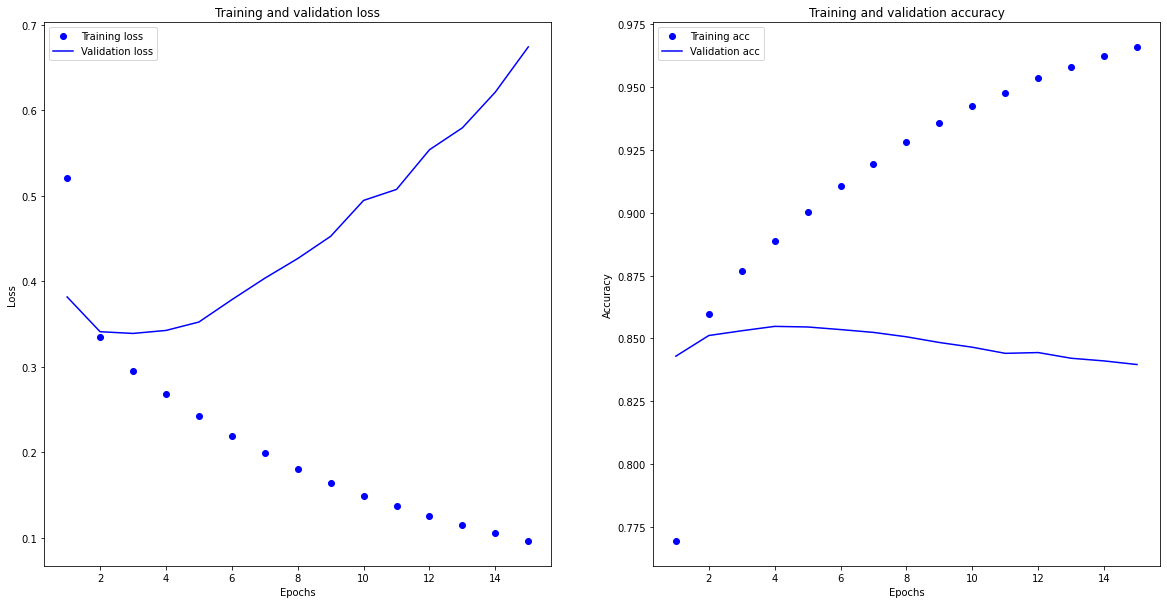

In [ ]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,10))
# loss 비교
ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# accuracy 비교
ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

그래프로 확인한결과 epoch=3에서 validation의 loss가 가장낮았고, accuracy가 가장 높았다.
# 1-D CNN

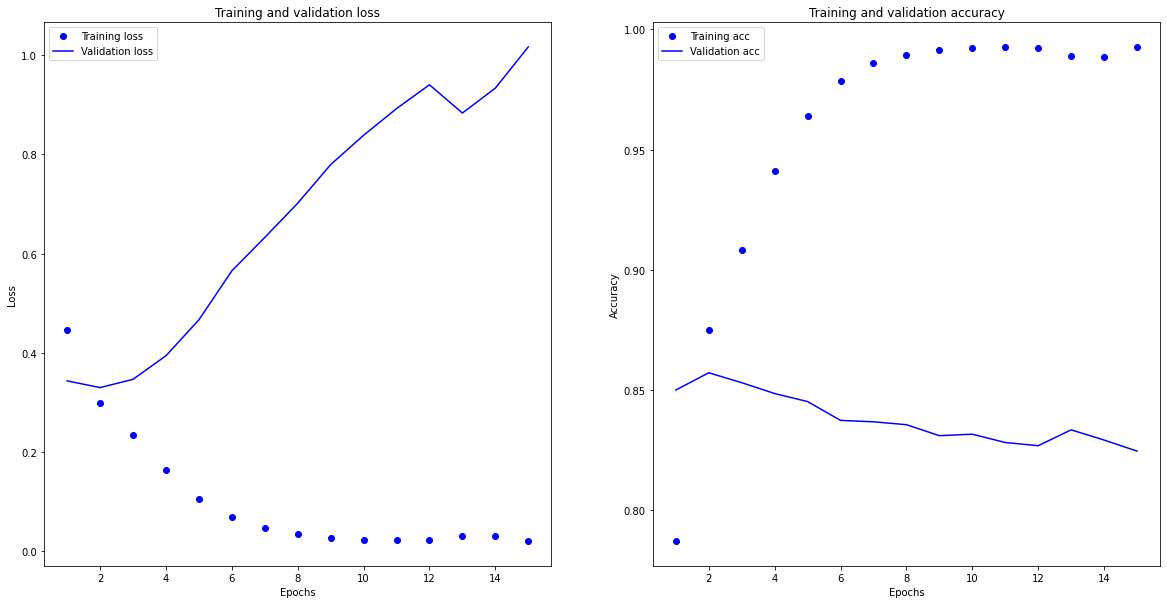

In [ ]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,10))
# loss 비교
ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# accuracy 비교
ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

이 모델에서는 epoch=2에서 validation의 loss가 가장낮고, accuracy가 가장 높습니다.
# GlobalAveragePooling1D layer

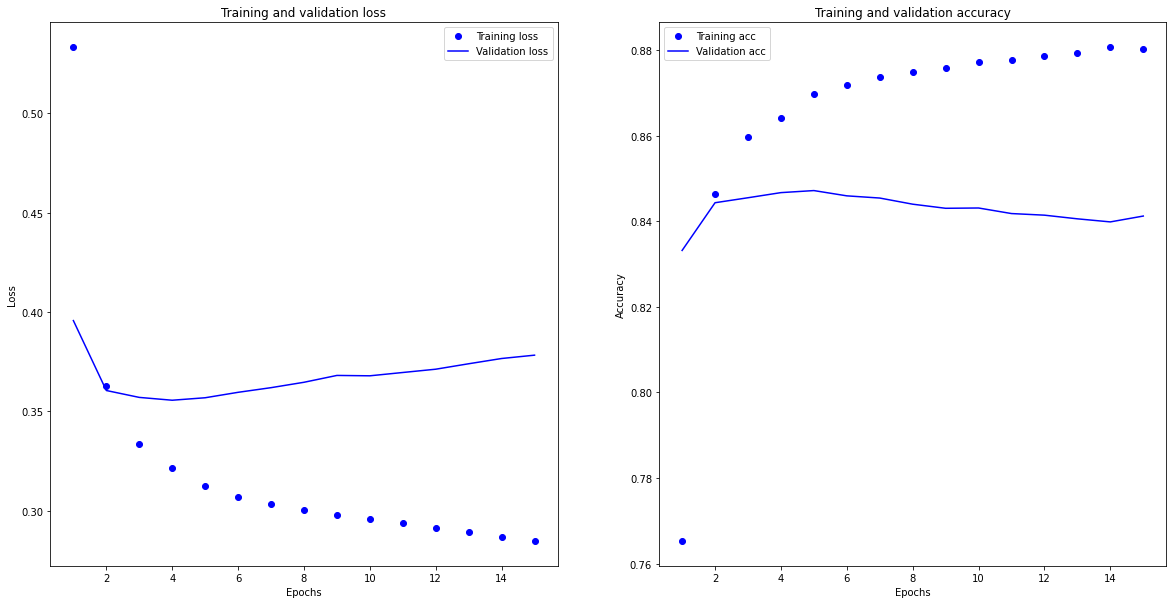

In [ ]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,10))
# loss 비교
ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# accuracy 비교
ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

epoch=4에서 validation의 loss가 가장낮다.

# Step8. 모델 재훈련 및 재평가
각 모델마다 최적의 epoch수로 훈련한다음 평가해보겠습니다.

In [14]:
# LSTM
lstm_re = keras.Sequential()
lstm_re.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_re.add(keras.layers.LSTM(8))
lstm_re.add(keras.layers.Dense(8, activation='relu'))
lstm_re.add(keras.layers.Dense(1, activation='sigmoid'))

# 1-D CNN
cnn_re = keras.Sequential()
cnn_re.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn_re.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_re.add(keras.layers.MaxPooling1D(5))
cnn_re.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_re.add(keras.layers.GlobalMaxPooling1D())
cnn_re.add(keras.layers.Dense(16, activation='relu'))
cnn_re.add(keras.layers.Dense(1, activation='sigmoid'))

# one GlobalAveragePooling layer
simple_re = keras.Sequential()
simple_re.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple_re.add(keras.layers.GlobalAveragePooling1D())
simple_re.add(keras.layers.Dense(8, activation='relu'))
simple_re.add(keras.layers.Dense(1, activation='sigmoid'))

# LSTM
epochs = 3
lstm_re.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm_re = lstm_re.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 1-D CNN              
epochs = 2
cnn_re.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn_re = cnn_re.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# one GlobalAveragePooling layer
epochs = 4 
simple_re.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple_re = simple_re.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# LSTM
print("LSTM")
results_lstm = lstm_re.evaluate(X_test, y_test, verbose=2)
print(results_lstm)


# 1-D CNN
print("1-D CNN")
results_cnn = cnn_re.evaluate(X_test, y_test, verbose=2)
print(results_cnn)


# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple_re.evaluate(X_test, y_test, verbose=2)
print(results_simple)

Epoch 1/3
229/229 [==============================] - 9s 11ms/step - loss: 0.4606 - accuracy: 0.7930 - val_loss: 0.3583 - val_accuracy: 0.8454
Epoch 2/3
229/229 [==============================] - 2s 8ms/step - loss: 0.3226 - accuracy: 0.8649 - val_loss: 0.3447 - val_accuracy: 0.8509
Epoch 3/3
229/229 [==============================] - 2s 8ms/step - loss: 0.2894 - accuracy: 0.8801 - val_loss: 0.3426 - val_accuracy: 0.8536
Epoch 1/2
229/229 [==============================] - 9s 8ms/step - loss: 0.4439 - accuracy: 0.7876 - val_loss: 0.3479 - val_accuracy: 0.8458
Epoch 2/2
229/229 [==============================] - 2s 7ms/step - loss: 0.2991 - accuracy: 0.8757 - val_loss: 0.3310 - val_accuracy: 0.8555
Epoch 1/4
229/229 [==============================] - 2s 6ms/step - loss: 0.5483 - accuracy: 0.7555 - val_loss: 0.4050 - val_accuracy: 0.8294
Epoch 2/4
229/229 [==============================] - 1s 6ms/step - loss: 0.3677 - accuracy: 0.8459 - val_loss: 0.3641 - val_accuracy: 0.8451
Epoch 3/4
22

### LSTM
loss: 0.6778 -> 0.3506   
accuracy: 0.8391 -> 0.8481 

### 1-D CNN
loss: 1.0267 -> 0.3373   
accuracy: 0.8261 -> 0.8552

### GlobalAveragePooling1D layer
loss: 0.3839 -> 0.3647   
accuracy: 0.8388 -> 0.8436

epoch수를 적절하게주니 성능이 향상된것을 확인할 수 있습니다.


# Step9. 학습된 Embedding 레이어 분석
우리의 감성분류모델이 잘 학습되었다면, Embedding레이어에 학습된 우리의 워드벡터들도 의미공간상에 유의미한 형태로 학습되었을 것입니다. 한번 확인해봅시다.

In [15]:
# 각 모델의 embedding레이어의 학습된 파라미터를 불러옵니다.
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

# 각 모델에서 학습한 Embedding 파라미터를 파일에 써서 저장하고, 워드벡터를 파일에 기록합니다.
word2vec_file_path_lstm = '/content/drive/MyDrive/Exploration_Data/ex8/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = '/content/drive/MyDrive/Exploration_Data/ex8/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = '/content/drive/MyDrive/Exploration_Data/ex8/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# gensim에서 제공하는 패키지를 이용해, 위에서 기록한 임베딩 파라미터를 읽어서 워드벡터로 활용할 수 있습니다.
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

love의 워드벡터를 뽑아봅시다.

In [16]:
word_vectors_lstm['배우']

array([-0.01199415, -0.03904248, -0.02834315, -0.04132614, -0.04912091,
       -0.00369572, -0.02101088, -0.01012273,  0.04039432, -0.03634325,
       -0.04770596,  0.02330395, -0.04677956,  0.02888172,  0.01529131,
        0.01358104,  0.02554793, -0.00369247,  0.03494194, -0.01049959,
        0.04121914,  0.00361197, -0.0240436 , -0.04423371, -0.04275915,
       -0.00277932,  0.03882157,  0.03280394, -0.0167039 , -0.03753478,
        0.04233963, -0.01110805,  0.01850775, -0.04056568, -0.03926761,
        0.03425819,  0.02081677,  0.00600005, -0.03908116,  0.03550898,
        0.04857211, -0.00311558, -0.02033389,  0.02710643,  0.00659144,
       -0.02884301, -0.0470481 ,  0.02689452, -0.00403278, -0.04907119,
        0.0249658 ,  0.01935966, -0.04195846,  0.04977334,  0.00692462,
       -0.01927794, -0.04476476,  0.02290637,  0.0369074 , -0.03180386,
        0.00147017, -0.03254851, -0.04679778, -0.03606772,  0.04294163,
        0.00544405, -0.01433926, -0.01260455, -0.01868746,  0.04

워드벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법은 단어하나와 유사한 단어를 출력해보는 것입니다.

In [17]:
word_vectors_lstm.similar_by_word("배우")

[('점프', 0.26517772674560547),
 ('서로', 0.254358172416687),
 ('조카', 0.25266098976135254),
 ('썅', 0.23933501541614532),
 ('으며', 0.23586106300354004),
 ('학생', 0.23533517122268677),
 ('우연히', 0.23370225727558136),
 ('수년', 0.22750626504421234),
 ('아마존', 0.22482405602931976),
 ('소외', 0.2119571417570114)]

'배우'라는 단어와 유사한 다른 단어를 잘 찾았다고 느껴지지는 않습니다. 아무래도 잠깐 학습한것만으로는 유의미한 학습이 이루어지기는 어려운거같습니다. 따라서 사전학습된 모델을 가져다 활용해 보겠습니다.

# Step10. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [18]:
import pprint

path = '/content/drive/MyDrive/Exploration_Data/ex8/word2vec_ko.model'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"])
pprint.pprint(ko_vec.wv.most_similar("배우"))

ko_vec = ko_vec.wv

[-0.58881295 -4.3877287  -3.4858546  -2.3084912   0.87703085  6.4445586
 -1.1062126  -2.2230182  -0.78621733  1.9408462  -1.1357461   1.0119969
 -0.30329964 -5.455517    2.6356647  -5.2909884  -1.744448    2.5409734
  3.716852   -1.4752581  -1.1985137   3.5504315  -0.41522408 -0.2436183
  1.5218438  -3.4603841   1.1120543   0.39729053 -2.707328    1.3680482
 -4.2843776   3.014664    2.6393197   0.9804478  -1.0825127   3.6201363
  3.1546066   0.9634868   1.3677765   0.82937515  1.9380125  -2.6699877
 -0.41389105  2.7402463   3.415545   -0.37949705  4.4021254   1.2531414
  2.504994    0.33631453 -2.0658643  -3.1885884   6.659477   -5.47897
  3.1113489   1.6667893   2.8441331  -1.1597652  -0.19843072 -0.07214008
  0.47545317  4.105001   -0.20690314 -4.399607   -0.32254001  2.030352
  0.35149667 -4.0907154   1.12323    -1.873176    2.422429    1.9751279
 -0.9144355   4.34507    -1.0122209   3.4604955  -2.2505796  -5.2072535
  1.4032923   0.7049264   2.6884458   0.11147156  1.4308741   0.03

이전 제가 만들었던 모델에 비해 훨씬 의미적으로 유사하네요.
이제 이전에 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜보겠습니다.

In [19]:
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 100

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

# 네트워크 구성
vocab_size = 10000
word_vector_dim = 100 

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

# one GlobalAveragePooling1D layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))


## 모델 훈련

In [20]:
epochs = 4

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                    
epochs = 8

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
229/229 [==============================] - 4s 13ms/step - loss: 0.4707 - accuracy: 0.7720 - val_loss: 0.3883 - val_accuracy: 0.8244
Epoch 2/4
229/229 [==============================] - 3s 13ms/step - loss: 0.3542 - accuracy: 0.8438 - val_loss: 0.3503 - val_accuracy: 0.8412
Epoch 3/4
229/229 [==============================] - 2s 11ms/step - loss: 0.3068 - accuracy: 0.8682 - val_loss: 0.3314 - val_accuracy: 0.8570
Epoch 4/4
229/229 [==============================] - 3s 11ms/step - loss: 0.2747 - accuracy: 0.8845 - val_loss: 0.3292 - val_accuracy: 0.8576
Epoch 1/10
229/229 [==============================] - 6s 22ms/step - loss: 0.7067 - accuracy: 0.6485 - val_loss: 0.5473 - val_accuracy: 0.7181
Epoch 2/10
229/229 [==============================] - 5s 20ms/step - loss: 0.5073 - accuracy: 0.7506 - val_loss: 0.4581 - val_accuracy: 0.7869
Epoch 3/10
229/229 [==============================] - 5s 20ms/step - loss: 0.4550 - accuracy: 0.7834 - val_loss: 0.4051 - val_accuracy: 0.8141
Epo

## 모델 평가

In [21]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# one GlobalAveragePooling1D layer
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 4s - loss: 0.3338 - accuracy: 0.8581 - 4s/epoch - 2ms/step
[0.333842396736145, 0.8581483960151672]
1537/1537 - 4s - loss: 0.3469 - accuracy: 0.8476 - 4s/epoch - 2ms/step
[0.3469126522541046, 0.84757000207901]
1537/1537 - 2s - loss: 0.3675 - accuracy: 0.8392 - 2s/epoch - 2ms/step
[0.3674965500831604, 0.83916836977005]


# 회고
- 이번 EX8은 처음부터 조금 고난이었는데 Mecab을 설치하는데 시행착오가 좀 있었다. 그래도 구글링을 통해 여러시도끝에 Mecab을 성공적으로 불러왔다. 
- 진행하면서 총 3가지 모델을 사용했는데, LSTM모델이 아니더라도 다른 모델도 성공적으로 잘 작동되었고 특히 one GlobalAveragePooling layer모델이 다른모델에비해 훈련시간이 매우 빠르다는것을 느꼈다. 빠른훈련속도에비해 성능도 뒤쳐지지않아서 효율이 좋은 모델인것같다.
- 에포크를 어떻게 설정하느냐에따라 모델의 성능이 많이 달라진다는것을 배웠다.
- 워드벡터개념에대해 한층더 깊게 이해할 수 있는시간이었다.
- 사전학습된 임베딩모델을 활용함으로써 전이학습에대해 배울 수 있었다.